# สกัดค่า dbz & rain ของ ppis/cappis ให้อยู่ใน dataframe เดียวกัน
* สกัดค่าของแต่ละโฟลเดอร์ ppis/cappis เก็บไว้ใน gdf แยก  ค่าที่สกัดนี้ใช้ระยะทาง 240 km
* นำมารวมกันด้วยการเลือกคอลัมน์ values ที่เก็บค่า dbz ของแต่ละข้อมูลไว้ แล้วทำการ rename ชื่อคอลัมน์
* เลือกคอลัมน์เฉพาะค่าที่ต้องการ 
* vis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import rasterio
import os

In [2]:
dir_ga = '../2results/0_outp_rain_hr/'  #ฝนสถานี สสน. ที่จะใช้เป็น target
fn_ga= []
for file in os.listdir(dir_ga):
    if file.endswith('.csv'):
        fn_ga.append(file)

In [3]:
dir_rad_paths = ['../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi1km/',
                '../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi2km/',
                '../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi3km/',
                '../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi4km/'] #เรดาร์ dbz ที่จะใช้เป็น features
#name_short = [os.path.basename(path.rstrip('/')) for path in dir_rad_paths]

In [4]:
def extract_dbz_by_stationRain(col_name,fn_rad,fn_ga,dir_rad,dir_ga):
    '''
    ฟังก์ชั่นที่จะใช้สกัดค่า dbz ตามพิกัดสถานีวัดน้ำฝน HAII แล้ว append ใน list
    '''
    crs = 'epsg:4326'  # Use this format for newer versions of GeoPandas
    dbz_rain = []
    for fn_r in fn_rad:
        for fn_g in fn_ga:
            if fn_r[:10] == fn_g[:10]:
                #print('> do extract dbz by location of gauge: ', fn_r[:10])

                # Read radar file
                rt = rasterio.open(dir_rad + fn_r)

                # Read rain gauge file
                df = pd.read_csv(dir_ga + fn_g)

                # Convert rain gauge positions to GeoDataFrame
                geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
                gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

                # Sample radar data at rain gauge locations
                gdf["value"] = [float(x) for x in rt.sample([(x, y) for x, y in zip(gdf["geometry"].x, gdf["geometry"].y)])]

                # Append GeoDataFrame to the list
                dbz_rain.append(gdf)

                # Close files
                rt.close()


    # Combine all GeoDataFrames into a single GeoDataFrame
    df=gpd.GeoDataFrame(pd.concat(dbz_rain, ignore_index=True), crs=crs)
    df.rename(columns={"value": col_name}, inplace=True) #เปลี่ยนชื่อคอลัมน์

    return df
   

## โปรแกรมหลักที่ใช้ run

In [5]:
gdf_rads=[]
for ci, dir_rad in enumerate(dir_rad_paths):
    print('>processing...', dir_rad)
    fn_rad = []
    
    for file in os.listdir(dir_rad):
        if file.endswith('.tif'):
            fn_rad.append(file)
    
    #สกัดฝน dbz ด้วย ฝนสถานี
    col_name=os.path.basename(dir_rad.rstrip('/'))
    ex_gdf_rad=extract_dbz_by_stationRain(col_name,fn_rad,fn_ga,dir_rad,dir_ga)
    gdf_rads.append(ex_gdf_rad)   
    
    print('..........................................................................\n')

>processing... ../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi1km/
..........................................................................

>processing... ../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi2km/
..........................................................................

>processing... ../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi3km/
..........................................................................

>processing... ../2results/00outp_cappi_ppi_hourly_phs2018_mean_dBZ/0train_val_models/cappi/cappi4km/
..........................................................................



## รวม geodataframe และเลือกคอลัมน์ที่ต้องการ

In [6]:
from functools import reduce
# Define the columns for merging
merge_columns = ['full_date', 'code'] #คอลัมน์ที่จะใช้เป็นตัว merge เลือกมา 2 อัน
# Merge GeoDataFrames using functools.reduce
merged_gdf = reduce(lambda left, right: pd.merge(left, right, on=merge_columns), gdf_rads) #รวม geodataframe ของค่า dbz ในแต่ละ cappis/ppis
merged_gdf = merged_gdf[[os.path.basename(path.rstrip('/')) for path in dir_rad_paths]+['full_date', 'code', 'rain_x']]
df_org = merged_gdf.loc[:, ~merged_gdf.columns.duplicated()] #ลบคอลัมน์ที่ซ้ำ
df = df_org
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\2432292253.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'station_x', 'date_x', 'name_x', 'tambon_x', 'station_type_x', 'geometry_x', 'time_x', 'province_x', 'basin_x', 'region_x', 'lat_x', 'Unnamed: 0_x', 'long_x', 'rain_x', 'amphoe_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_gdf = reduce(lambda left, right: pd.merge(left, right, on=merge_columns), gdf_rads) #รวม geodataframe ของค่า dbz ในแต่ละ cappis/ppis


,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,NaN,NaN,NaN,NaN,2018-06-01-00:00,BDLH,0.0
1,NaN,NaN,NaN,NaN,2018-06-01-00:00,BRKM,0.0
2,NaN,NaN,NaN,NaN,2018-06-01-00:00,BWKG,0.0
3,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
4,NaN,NaN,NaN,NaN,2018-06-01-00:00,CNDN,0.0
...,...,...,...,...,...,...,...
51081,NaN,NaN,NaN,NaN,2018-09-21-23:00,WSPN,0.0
51082,NaN,NaN,NaN,NaN,2018-09-21-23:00,WTBT,0.0
51083,NaN,NaN,NaN,NaN,2018-09-21-23:00,WTLG,0.0
51084,NaN,NaN,NaN,NaN,2018-09-21-23:00,YOM008,0.0


## save to csv

In [7]:
# save to csv
df_org.to_csv('../2results/df_org_dbz_rain_inbasin_120km.csv')
df.to_csv('../2results/df_org_dbz_noNan_rain_inbasin_120km.csv')

In [8]:
df.drop(['full_date', 'code'], axis=1, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\1817707663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['full_date', 'code'], axis=1, inplace=True)


In [9]:
df

,cappi1km,cappi2km,cappi3km,cappi4km,rain_x
0,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,NaN,0.0
3,24.691301,24.196701,20.083112,20.643747,0.0
4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...
51081,NaN,NaN,NaN,NaN,0.0
51082,NaN,NaN,NaN,NaN,0.0
51083,NaN,NaN,NaN,NaN,0.0
51084,NaN,NaN,NaN,NaN,0.0


## Visualization

array([[<AxesSubplot: xlabel='cappi1km', ylabel='cappi1km'>,
        <AxesSubplot: xlabel='cappi2km', ylabel='cappi1km'>,
        <AxesSubplot: xlabel='cappi3km', ylabel='cappi1km'>,
        <AxesSubplot: xlabel='cappi4km', ylabel='cappi1km'>,
        <AxesSubplot: xlabel='rain_x', ylabel='cappi1km'>],
       [<AxesSubplot: xlabel='cappi1km', ylabel='cappi2km'>,
        <AxesSubplot: xlabel='cappi2km', ylabel='cappi2km'>,
        <AxesSubplot: xlabel='cappi3km', ylabel='cappi2km'>,
        <AxesSubplot: xlabel='cappi4km', ylabel='cappi2km'>,
        <AxesSubplot: xlabel='rain_x', ylabel='cappi2km'>],
       [<AxesSubplot: xlabel='cappi1km', ylabel='cappi3km'>,
        <AxesSubplot: xlabel='cappi2km', ylabel='cappi3km'>,
        <AxesSubplot: xlabel='cappi3km', ylabel='cappi3km'>,
        <AxesSubplot: xlabel='cappi4km', ylabel='cappi3km'>,
        <AxesSubplot: xlabel='rain_x', ylabel='cappi3km'>],
       [<AxesSubplot: xlabel='cappi1km', ylabel='cappi4km'>,
        <AxesSubplot: xlabe

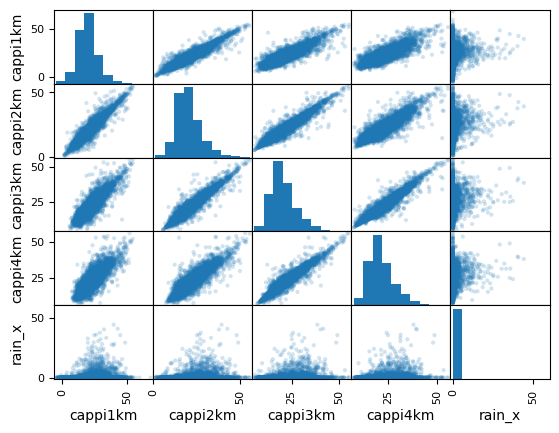

In [10]:
pd.plotting.scatter_matrix(df, alpha=0.2)

### พลอต scatter ด้วย seaborn

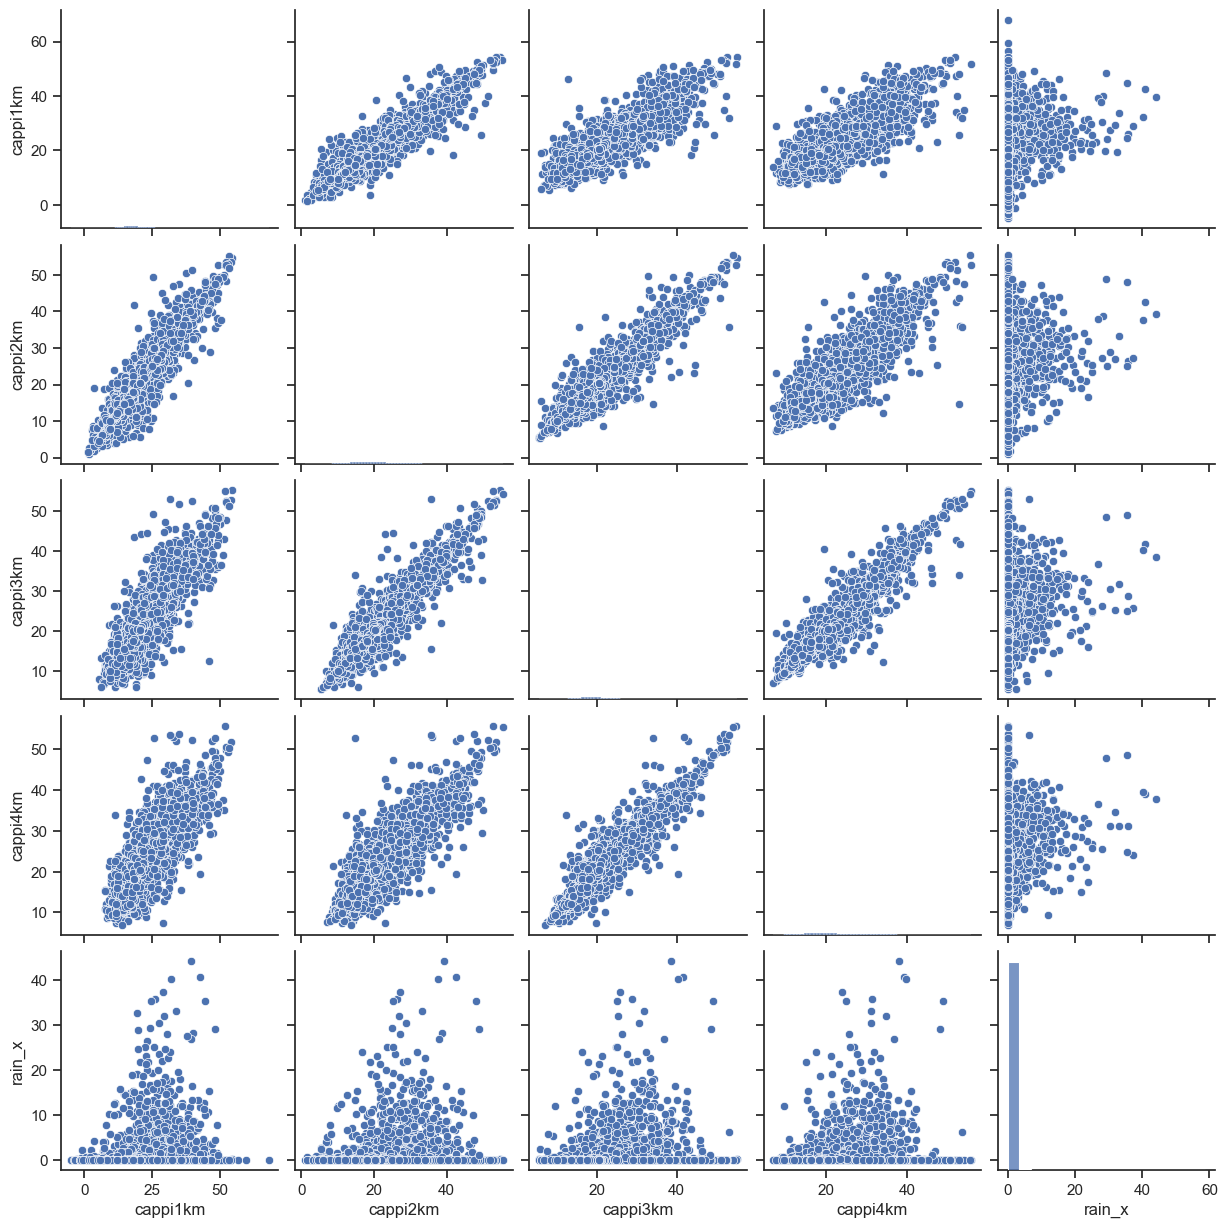

In [11]:
import seaborn as sns
sns.set_theme(style="ticks")

#df = sns.load_dataset("penguins")
sns.pairplot(df)

In [12]:
df.corr()

,cappi1km,cappi2km,cappi3km,cappi4km,rain_x
cappi1km,1.000000,0.948471,0.886002,0.818513,0.206199
cappi2km,0.948471,1.000000,0.955191,0.886618,0.225006
cappi3km,0.886002,0.955191,1.000000,0.957117,0.232219
cappi4km,0.818513,0.886618,0.957117,1.000000,0.227327
rain_x,0.206199,0.225006,0.232219,0.227327,1.000000


### พลอต heat map of correlation matrix 
https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

### พลอตแบบยังไม่ remove nan

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\41050538.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


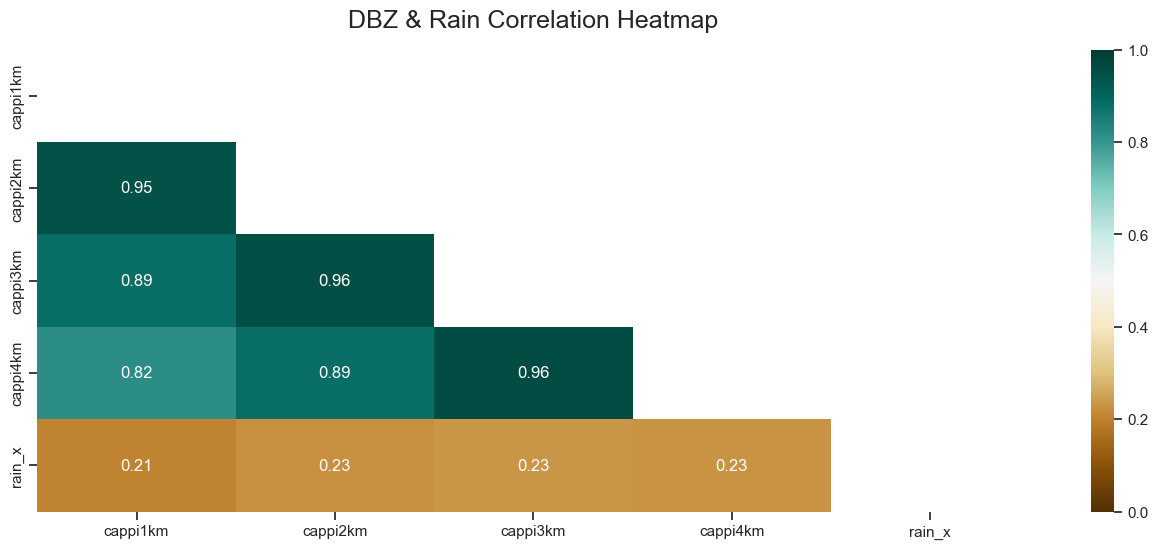

In [13]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DBZ & Rain Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

### พลอตแบบ remove nan

In [14]:
## drop ค่า nan
df.dropna(axis=0, how='any', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\2983215672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, how='any', inplace=True)


In [15]:
df

,cappi1km,cappi2km,cappi3km,cappi4km,rain_x
3,24.691301,24.196701,20.083112,20.643747,0.0
10,25.330028,23.526070,23.449750,24.210546,0.0
14,27.172401,27.172401,27.172403,27.172401,0.0
17,22.804799,24.250445,26.664243,27.962598,0.0
37,21.018023,24.855865,23.057179,23.257894,0.0
...,...,...,...,...,...
50697,18.235903,17.662603,17.961360,18.214892,0.0
50707,43.466267,42.750593,44.344063,43.383757,0.0
50735,16.701266,15.322284,13.358064,12.000171,0.0
50753,24.601331,24.696486,24.310151,23.377122,0.2


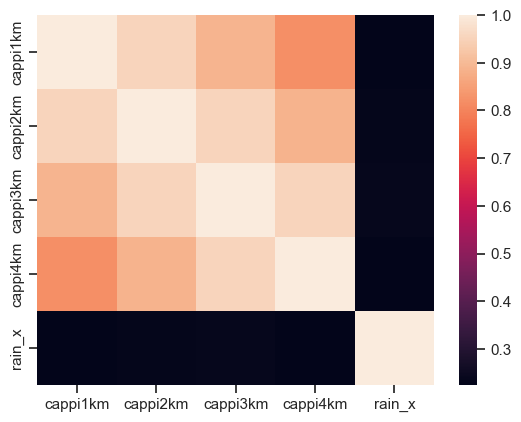

In [16]:
sns.heatmap(df.corr());

### พลอตแบบมีตัวอักษร

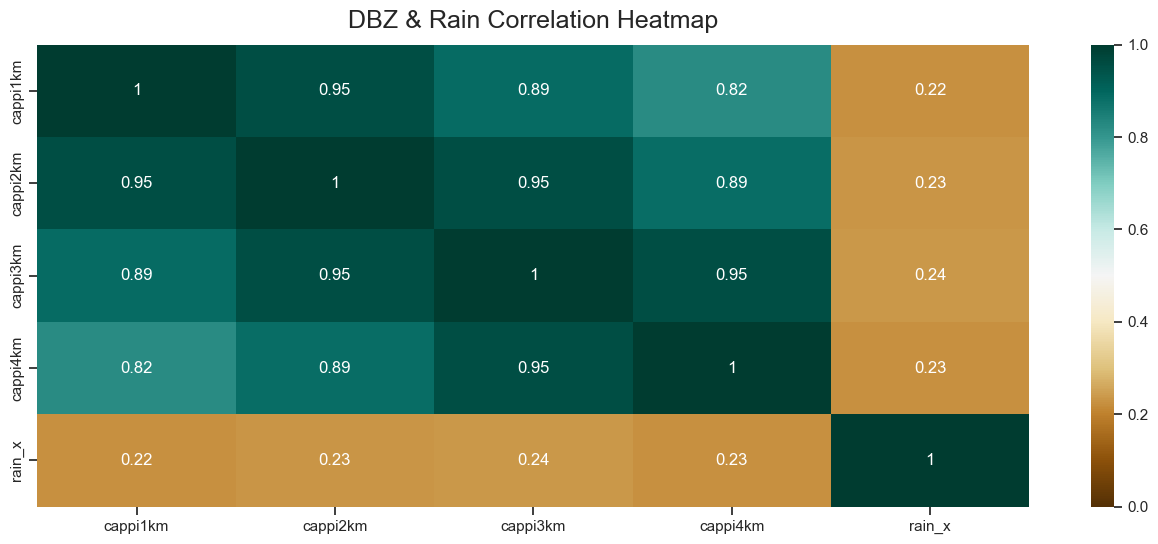

In [18]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DBZ & Rain Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('../2results/heatmap.png', dpi=300, bbox_inches='tight')

### พลอตแบบสามเหลี่ยม

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\41050538.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


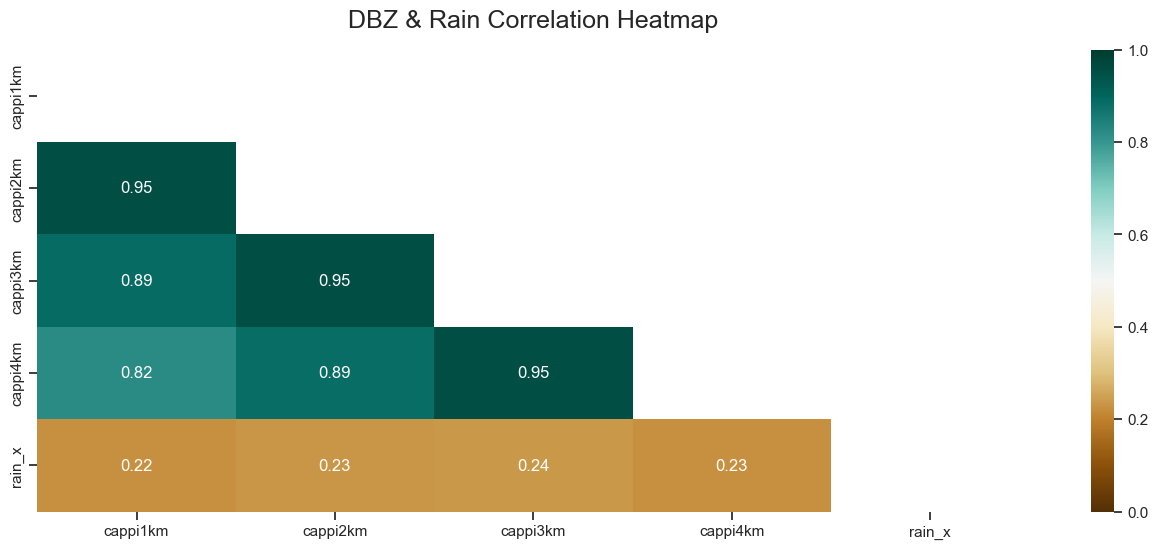

In [19]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DBZ & Rain Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

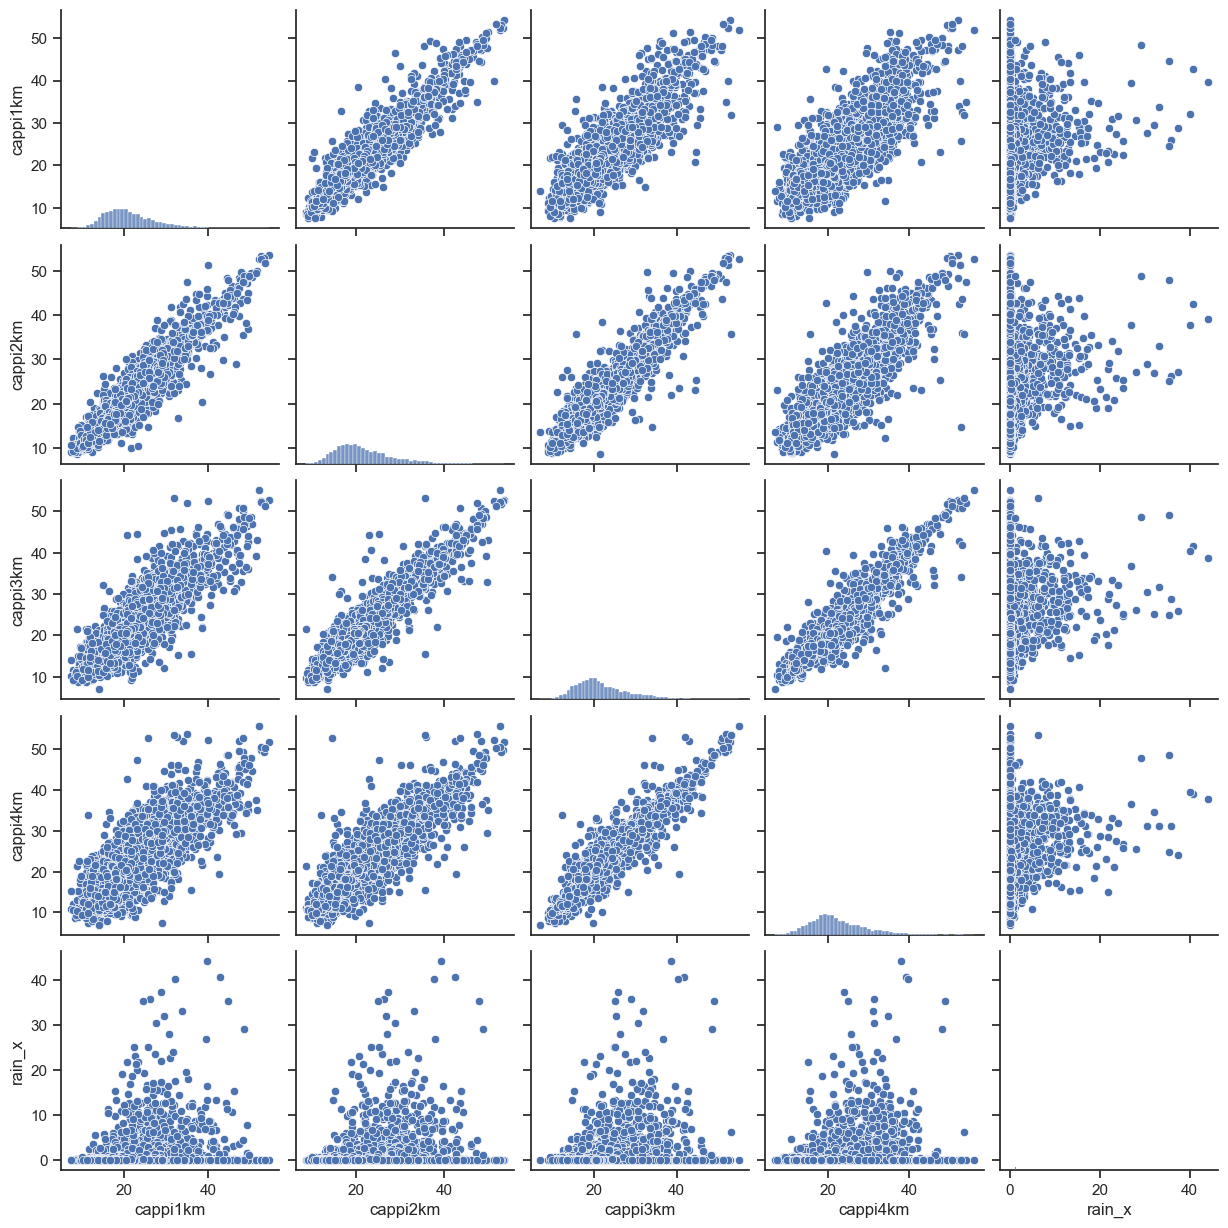

In [20]:
sns.set_theme(style="ticks")
sns.pairplot(df)

## ทดสอบกรองฝน สสน.ที่มากกว่า 0 mm หรือ conditional rain HAII

In [21]:
df.drop(df[df['rain_x'] == 0].index, inplace = True)
#df=df.reset_index()
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\3160669723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['rain_x'] == 0].index, inplace = True)


,cappi1km,cappi2km,cappi3km,cappi4km,rain_x
52,22.267728,22.656334,23.252944,23.492632,0.4
100,28.847841,28.025389,26.520176,24.078056,0.2
144,35.427362,33.911951,33.814425,34.668089,0.2
197,31.115211,31.477566,32.408463,33.207074,3.4
211,29.090362,29.558125,30.479992,31.064178,9.4


C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\41050538.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


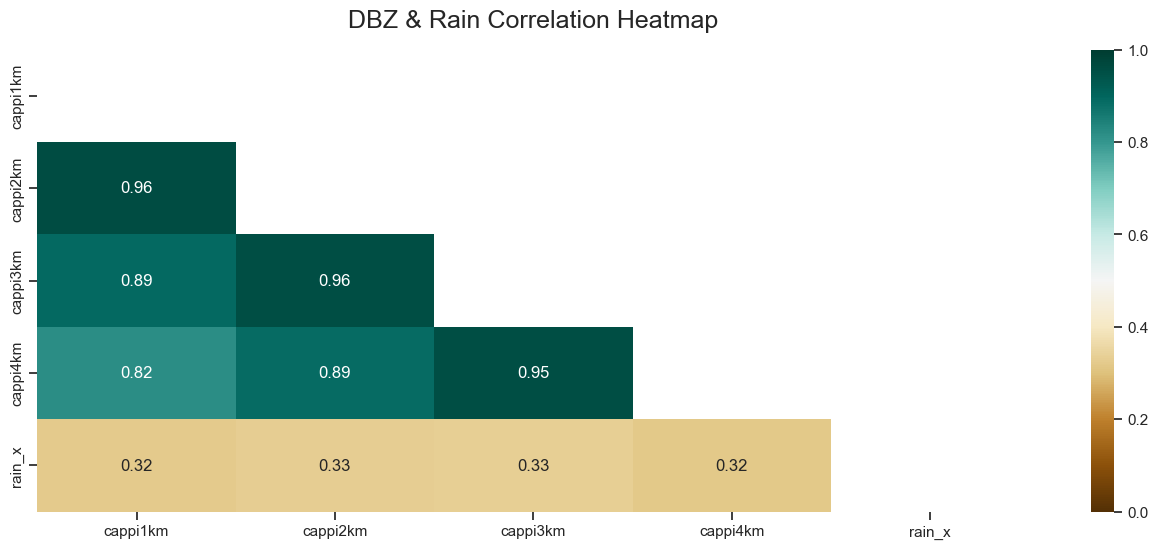

In [22]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DBZ & Rain Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## ทดสอบกรองฝน สสน.ที่มากกว่า >0.5 mm หรือ conditional rain HAII

In [23]:
df.drop(df[df['rain_x'] <= 0.5].index, inplace = True)
#df=df.reset_index()
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\1646768928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['rain_x'] <= 0.5].index, inplace = True)


,cappi1km,cappi2km,cappi3km,cappi4km,rain_x
197,31.115211,31.477566,32.408463,33.207074,3.4
211,29.090362,29.558125,30.479992,31.064178,9.4
233,32.088368,32.584628,33.464023,33.776123,2.4
251,26.734927,26.738897,26.897428,27.745147,0.6
265,25.850179,25.486442,25.565090,26.200280,0.8


In [24]:
#df

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\41050538.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


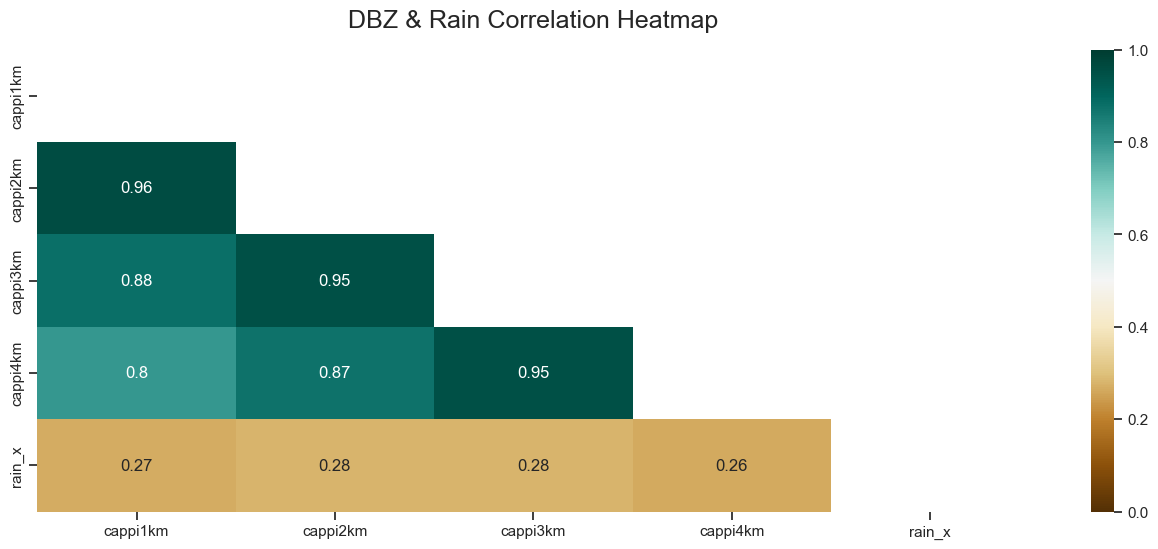

In [25]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DBZ & Rain Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## จำแนกฝนภาคพื้นดินตามความเข้มฝน 
* จากกรมอุตุนิยมวิทยา http://www.arcims.tmd.go.th/dailydata/DetailDailyRain.html
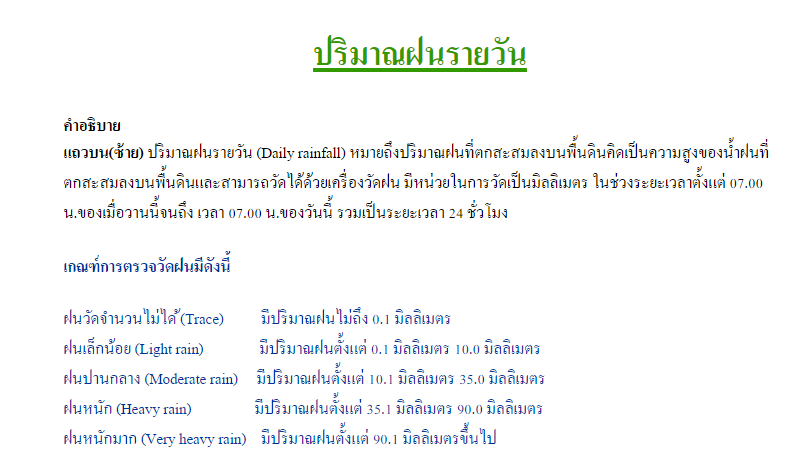

* จาก http://eng.sut.ac.th/ce/ce_course/download/project/7-1-55/51SOMPOB%20KAMDEE.pdf
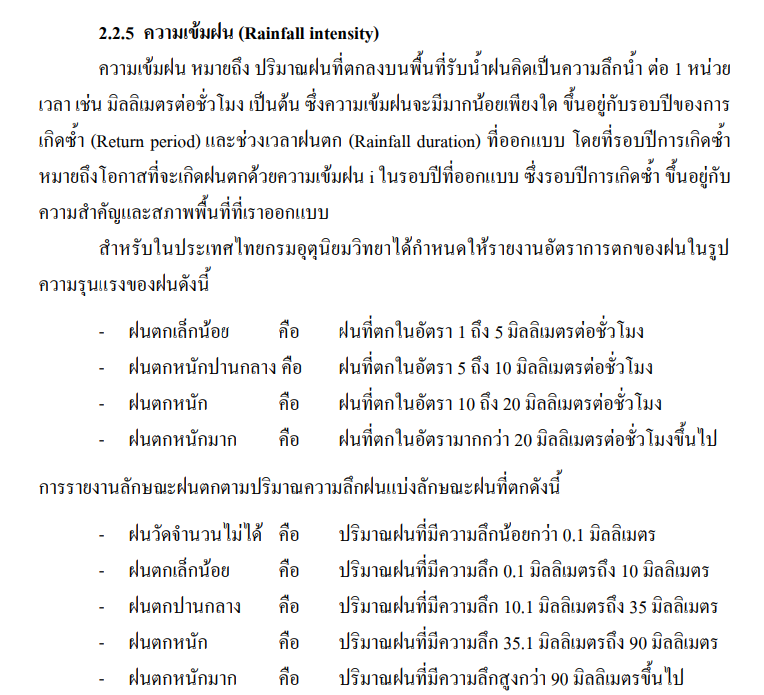


* จากกรมทรัพยากรน้ำ https://dwr.go.th/uploads/file/article/2013/article_th-20032013-133453-644145.pdf
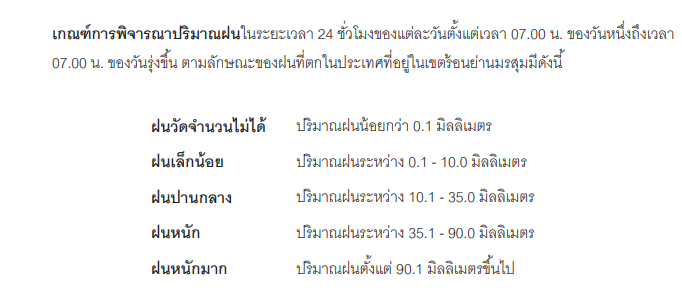


* rainfall intensity จาก wmo https://www.researchgate.net/publication/353769617_Erosion_Rate_of_the_Aliano_Biancana_Badlands_Based_on_a_3D_Multi-Temporal_High-Resolution_Survey_and_Implications_for_Wind-Driven_Rain
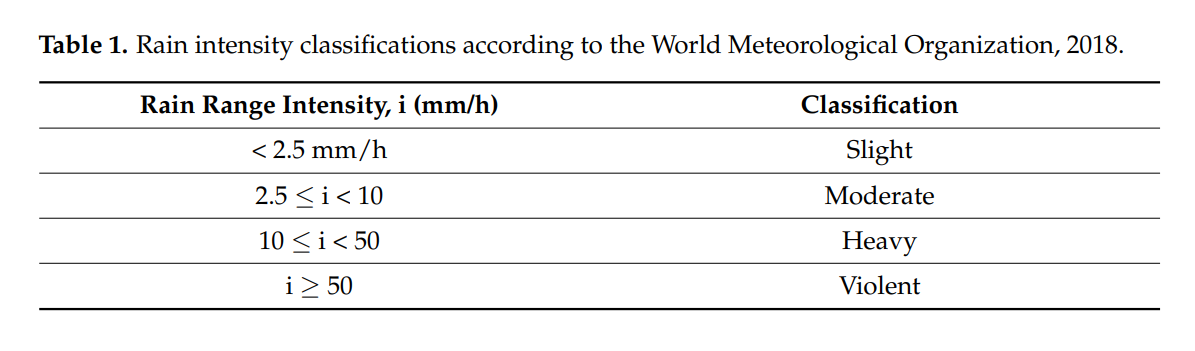

## จำแนกฝน สสน. 'rain_x' ตามความเข้มของฝนใช้คำนิยามของกรมอุตุนิยมวิทยา


In [27]:
df = pd.read_csv('../2results/df_org_dbz_rain_inbasin_120km.csv')
df.drop(df[df['rain_x'] <= 0.5].index, inplace = True)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
5,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
20,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
197,31.115211,31.477566,32.408463,33.207074,2018-06-01-04:00,CMSG,3.4
211,29.090362,29.558125,30.479992,31.064178,2018-06-01-04:00,NAN008,9.4
233,32.088368,32.584628,33.464023,33.776123,2018-06-01-04:00,TBW014,2.4
...,...,...,...,...,...,...,...
50610,31.854776,31.898127,31.546525,29.810020,2018-09-21-14:00,PIN003,2.4
50665,NaN,NaN,NaN,NaN,2018-09-21-15:00,PIN003,9.0
50823,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
50884,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### จำแนกฝนตาม WMO 2018

In [28]:
# จำแนกฝนตาม WMO 2018 https://www.researchgate.net/publication/353769617_Erosion_Rate_of_the_Aliano_Biancana_Badlands_Based_on_a_3D_Multi-Temporal_High-Resolution_Survey_and_Implications_for_Wind-Driven_Rain
df['rain_intensity'] = 'Slight'
df['rain_intensity'][df['rain_x'] <= 2.5] = 'Slight'
df['rain_intensity'][(df['rain_x'] > 2.5) & (df['rain_x'] <= 10.0)] = 'Moderate'
df['rain_intensity'][(df['rain_x'] > 10.0) & (df['rain_x'] <= 50.0)] = 'Heavy'
df['rain_intensity'][df['rain_x'] > 50.0] = 'Violent'
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\3435471277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_intensity'][df['rain_x'] <= 2.5] = 'Slight'
C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\3435471277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_intensity'][(df['rain_x'] > 2.5) & (df['rain_x'] <= 10.0)] = 'Moderate'
C:\Users\Admin\AppData\Local\Temp\ipykernel_32800\3435471277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x,rain_intensity
5,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8,Heavy
20,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6,Moderate
197,31.115211,31.477566,32.408463,33.207074,2018-06-01-04:00,CMSG,3.4,Moderate
211,29.090362,29.558125,30.479992,31.064178,2018-06-01-04:00,NAN008,9.4,Moderate
233,32.088368,32.584628,33.464023,33.776123,2018-06-01-04:00,TBW014,2.4,Slight
...,...,...,...,...,...,...,...,...
50610,31.854776,31.898127,31.546525,29.810020,2018-09-21-14:00,PIN003,2.4,Slight
50665,NaN,NaN,NaN,NaN,2018-09-21-15:00,PIN003,9.0,Moderate
50823,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0,Slight
50884,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8,Heavy


In [29]:
df.columns

Index(['cappi1km', 'cappi2km', 'cappi3km', 'cappi4km', 'full_date', 'code',
       'rain_x', 'rain_intensity'],
      dtype='object')

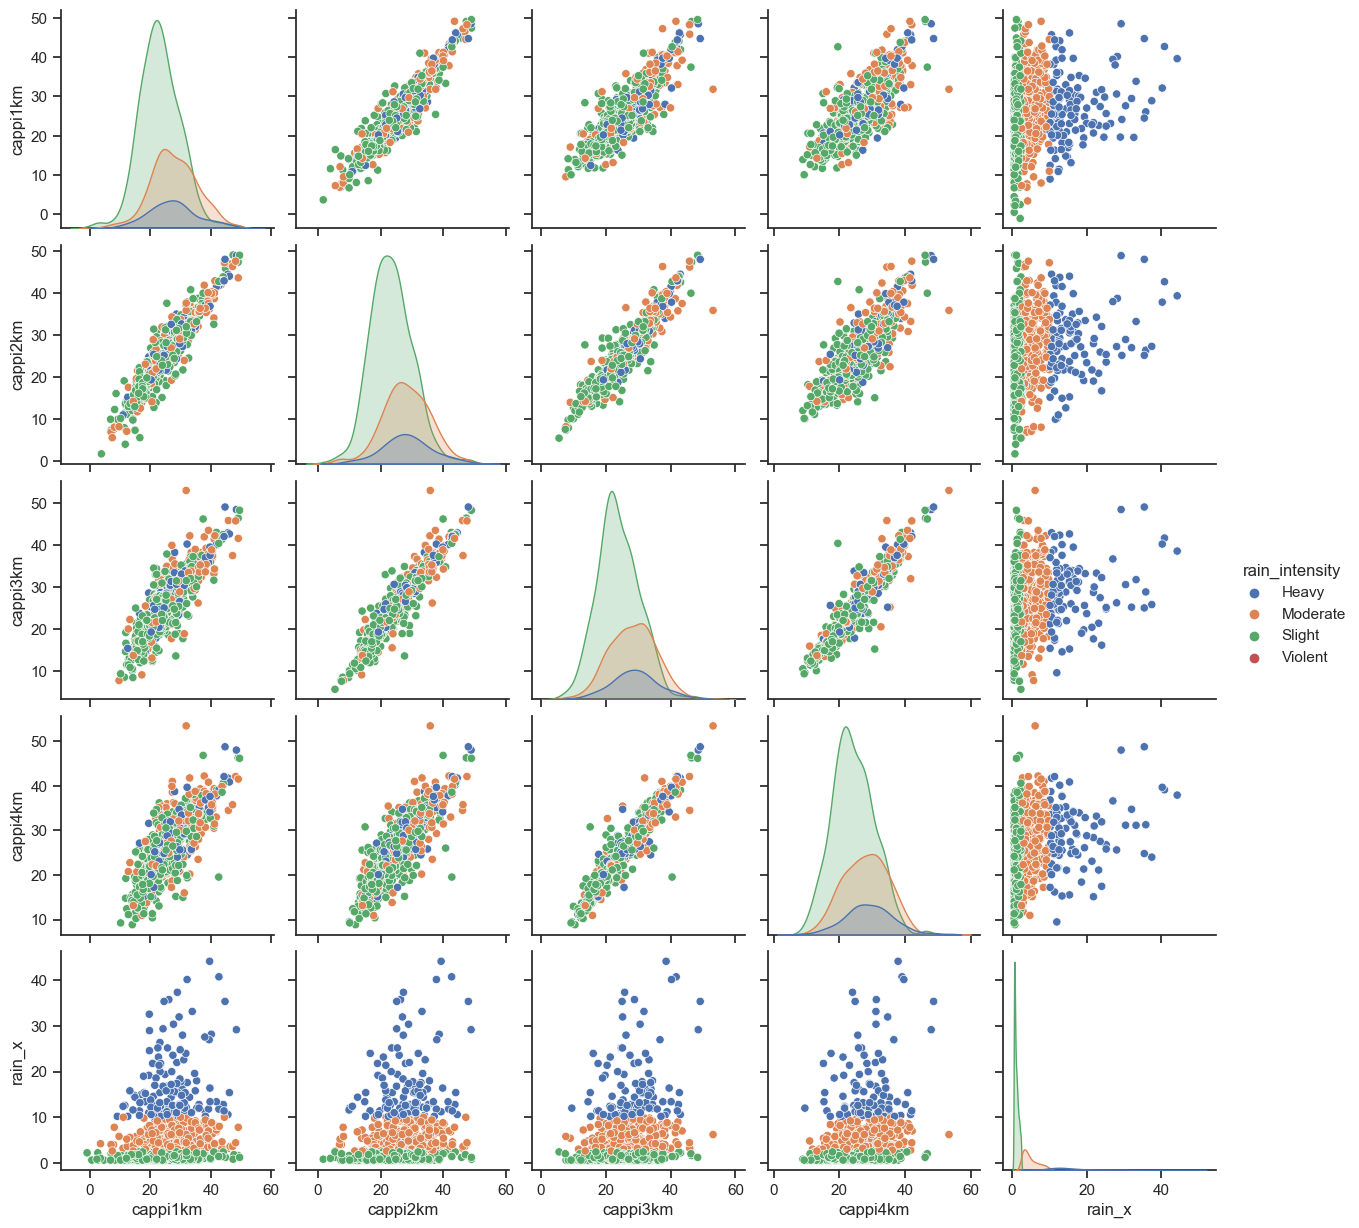

In [30]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="rain_intensity")

## สิ่งที่ต้องทำการทดลองต่อไป
* แปลง dBZ มุุมยกแรก เป็น rain rate ด้วย ZR 4 แบบ คือ MP, RF, SC, Tropical Storm แล้วพลอต EDA
* data split 70:30  เพื่อใช้เป็น x_test, xtrain, ytest, ytes tแล้วส่งออกเป็นไฟล์ csv เพื่อให้ไม่มีการเปลียนแปลงตอนทำแบบจำลอง
* density plot ระหว่างฝนชั่วโมง กับ ฝนรายวัน ของแต่ละ ZR
* ทดสอบ การสร้างแบบจำลอง ML เอาเฉพาะกลุ่มของ ensemble  เปรียบเทียบ รายวันและรายชั่วโมง ใช้ k-fold =10
* เปรียบเทียบค่าสถิติ ดูว่า MFB ลดไหม ทำกราฟเปรียบเทียบ รายวัน/รายชั่วโมง
* นำแบบจำลองที่ดีที่สุด มาสร้างเพื่อวิเคราะห์ ระดับฝนหนักเบา คือ >0, >5, >10 หรือ ตรม WMO vs TMD
* เปรียบเทียบค่าสถิติ ดูว่า MFB ลดไหม ทำกราฟเปรียบเทียบ รายวัน/รายชั่วโมง
* คิดการแสดงแผนที่ แบบ MFB ในแต่ละลุ่มน้ำ
